# Version information

In [2]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: May 14, 2022
Pyleecan version:1.3.8
SciDataTool version:2.3.10


# 클래스 용어집
이 자습서에서는 주로 다음 클래스를 사용합니다.

- [VarParam](https://pyleecan.org/pyleecan.Classes.VarParam.html): 변수를 변경하여 다중 시뮬레이션을 정의하는 클래스
- [VarLoadCurrent](https://pyleecan.org/pyleecan.Classes.VarLoadCurrent.html): 동작점을 달리하여 다중 시뮬레이션을 정의하는 클래스
- [DataKeeper](https://pyleecan.org/pyleecan.Classes.DataKeeper.html): 다중 시뮬레이션에서 보관할 일부 데이터를 선택하는 클래스
- [ParamExplorerInterval](https://pyleecan.org/pyleecan.Classes.ParamExplorerInterval.html): 간격에 대한 값으로 설계 변수(파라미터 스윕용)를 정의하는 클래스
- [ParamExplorerSet](https://pyleecan.org/pyleecan.Classes.ParamExplorerSet.html): 세트의 값으로 설계 변수(파라미터 스윕용)를 정의하는 클래스
- [Output](https://pyleecan.org/pyleecan.Classes.Output.html): 모든 모듈의 모든 출력을 수집하는 클래스
- [XOutput](https://pyleecan.org/pyleecan.Classes.XOutput.html): 여러 시뮬레이션을 위한 모든 모듈의 모든 출력을 수집하는 클래스

# 가변 속도 시뮬레이션의 Parameter Sweep을 정의하는 방법은 무엇입니까?
이 튜토리얼에서는 VarParam 및 VarLoadCurrent 개체를 사용하여 pyleecan의 다중 시뮬레이션 도구를 사용하여 가변 속도 시뮬레이션의 Parameter Sweep을 실행하는 방법을 설명합니다. 이 자습서는 pyleecan의 여러 고급 측면을 결합합니다. 먼저 다음 자습서를 읽으십시오.

- "[머신 정의 방법](https://pyleecan.org/tuto_Machine.html)"
- "[FEMM을 호출하는 시뮬레이션을 정의하는 방법](https://pyleecan.org/tuto_Simulation_FEMM.html)".
- "[동작점 설정 방법](https://pyleecan.org/tuto_Operating_point.html)".
- "[멀티시뮬레이션 실행 방법](https://pyleecan.org/tuto_multisimulation.html)".

Pyleecan의 다중 시뮬레이션 도구를 결합하여 다중 시뮬레이션의 다중 시뮬레이션을 생성할 수 있습니다.


-> 온도를 변화해가면서 매개변수 스윕


## 기계 및 참조 시뮬레이션 정의
첫 번째 단계는 VarParam(매개변수 스윕 개체) 또는 VarLoadCurrent(가변 속도 개체)에서 수정 없이 원본 머신이라고도 하는 참조 시뮬레이션을 정의하는 것입니다. 이 튜토리얼은 일반적인 기계인 Toyota Prius(2004)와 이전 튜토리얼의 시뮬레이션을 사용합니다.

In [3]:
%matplotlib notebook

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()

<IPython.core.display.Javascript object>

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, pi
# Initialization of the Simulation
simu_ref = Simu1(name="tuto_multi", machine=Toyota_Prius)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu_ref.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
# Run only Magnetic module
simu_ref.elec = None
simu_ref.force = None
simu_ref.struct = None

simu_ref.input = InputCurrent()
simu_ref.input.Nt_tot = 128 # Number of time step
simu_ref.input.Na_tot = 2048 # Spatial discretization

# Set reference simulation operating point
simu_ref.input.OP = OPdq(N0 = 2000) # Rotor speed [rpm]
simu_ref.input.OP.Tem_av_ref = 353
simu_ref.input.OP.set_I0_Phi0(I0=250/sqrt(2), Phi0=140*pi/180)

참조 시뮬레이션 "simu_ref"가 이제 완전히 정의되었습니다.
모든 것이 올바르게 정의되었는지 확인하기 위해 다중 시뮬레이션 전에 실행할 수 있습니다.

다중 시뮬레이션은 참조 시뮬레이션과 그 결과를 복사/업데이트합니다. 따라서 메모리와 계산 시간을 절약하기 위해 최소한의 입출력만 수정해야 합니다.

기준 시뮬레이션 출력은 비교 목적으로 사용됩니다.

In [6]:
from pyleecan.definitions import DATA_DIR
#from Tests import save_validation_path as save_path

DATA_DIR

'C:/Users/KDH2018-PC/anaconda3/envs/py38_pcan138_SDT_2310/Lib/site-packages/pyleecan/Data'

In [7]:
output_ref = simu_ref.run()

[21:47:18] Starting running simulation tuto_multi (machine=Toyota_Prius)
[21:47:18] Starting Magnetic module
[21:47:19] Computing Airgap Flux in FEMM
[21:47:25] End of simulation tuto_multi


이 튜토리얼에서는 주요 자기 출력에 초점을 맞출 것입니다. 예를 들어, 참조 시뮬레이션 후:

In [8]:

# Operating point
print("\nOperating Point:")
print("Rotor speed [rpm]:"+str(output_ref.elec.OP.N0))
print("Id [Arms]:"+str(output_ref.elec.OP.Id_ref))
print("Iq [Arms]:"+str(output_ref.elec.OP.Iq_ref))


Operating Point:
Rotor speed [rpm]:2000
Id [Arms]:-135.4188051049254
Iq [Arms]:113.62986941801093


동작점은 I0/Phi0으로 정의되어 있지만, pyleecan은 Id/Iq만 저장하고 사용합니다.

## 첫 번째 다중 시뮬레이션 레이어: 가변 속도

다음 단계는 가변 속도 시뮬레이션을 정의하는 것입니다. 이 자습서에서는 다음 결과를 사용합니다.
Z. Yang, M. Krishnamurthy 및 I. P. Brown, "최대 토크 속도 범위에서 IPM의 전자기 및 진동 특성", 2013 국제 전기 기계 및 드라이브 컨퍼런스, 일리노이주 시카고, 2013, pp. 295-302, doi: 10.1109/ IEMDC.2013.6556267.

각 pyleecan 시뮬레이션은 준정적이며 단일 작동 지점(고정 속도)에서 실행되는 것으로 가정합니다. 여러 작동 지점에서 시뮬레이션을 실행하려면 두 단계가 필요합니다.
- 먼저 단일 작동 지점(위에 정의된 것과 같은)에서 올바르게 실행되는 시뮬레이션을 정의합니다.
- 그런 다음 VarLoadCurrent 개체를 정의합니다.

VarLoadCurrent 개체는 각 행이 작동점에 해당하고 열이 다음과 같은 행렬로 정의됩니다.
- (N0, I0, Phi0) type_OP_matrix==0인 경우
- (N0, Id, Iq) type_OP_matrix==1인 경우

다음 VarLoadCurrent 개체는 Phi0 값을 변경하여 이전 시뮬레이션을 N_speed만큼 실행합니다.

is_torque=True를 설정하여 네 번째 열을 추가할 수 있습니다. 작동점에 대한 기준 토크를 정의할 수 있습니다. 기준 토크는 output.elec.Tem_av_ref에 저장되고 실제 계산된 토크는 output.mag.Tem_av에 저장됩니다.

Reference torque and current angle vector are:

In [19]:
from numpy import linspace, array, pi
import numpy as np
import matplotlib.pyplot as plt

Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_speed = Tem_av_ref.size
Phi0_ref
plt.plot((Tem_av_ref))


<IPython.core.display.Javascript object>

In [22]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange
varload=VarLoadCurrent()
#varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_speed,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_speed))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = 250/sqrt(2) * ones((N_speed)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)

# All the simulation use the same machine
# No need to draw the machine for all OP
varload.is_reuse_femm_file=True  

[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


이 첫 번째 레이어는 다음과 같이 작동합니다.
- 먼저 참조 출력을 얻기 위해 참조 시뮬레이션이 실행됩니다.
- 그런 다음 참조 시뮬레이션은 OP 매트릭스에 따라 업데이트된 InputCurrent 값으로 N_speed 번 복제됩니다.
- is_reuse_femm은 N_speed 시뮬레이션을 업데이트하여 참조 시뮬레이션에 그려진 FEMM 파일을 재사용하여 계산 속도를 높입니다.
- 목록의 각 시뮬레이션은 별도로 실행되고 결과는 XOutput 개체에 수집됩니다.

Pyleecan은 목록의 시뮬레이션이 참조 시뮬레이션과 일치하는 것을 감지하고 동일한 것을 두 번 계산하지 않도록 계산을 건너뛸 수 있습니다. 다중 시뮬레이션의 다중 시뮬레이션을 정의할 때 이 최적화는 pyleecan이 설계 매개변수의 각 조합에 대해 "1 + N_speed" 대신 "1 + (N_speed-1)" 시뮬레이션을 실행하기 때문에 필수적입니다.

pyleecan 다중 시뮬레이션 도구를 더 자세히 이해하기 위해 이 자습서에서는 모든 시뮬레이션의 모든 출력을 유지하는 "is_keep_all_output" 옵션을 사용합니다. 이 옵션을 사용하면 모든 작동 지점에 대한 플롯에 액세스할 수 있지만 시뮬레이션에 따라 상당한 메모리 공간을 차지할 수 있습니다.

In [11]:
simu_vop = simu_ref.copy()
simu_vop.var_simu = varload
simu_vop.var_simu.is_keep_all_output = True

# Speed-up computation (set reference simu input as first OP), here reference is already the 9th simulation
# simu_vop.input.set_OP_from_array(varload.OP_matrix, varload.type_OP_matrix)

In [12]:
Xout_vop = simu_vop.run()

[23:55:48] Starting running simulation tuto_multi (machine=Toyota_Prius)
[23:55:48] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[23:55:48] Computing reference simulation for Variable Load
[23:55:48] Starting Magnetic module
[23:55:49] Solving time step 1 / 16 in FEMM
[23:55:49] Solving time step 5 / 16 in FEMM
[23:55:49] Solving time step 9 / 16 in FEMM
[23:55:49] Solving time step 13 / 16 in FEMM
[23:55:49] Solving time step 2 / 16 in FEMM
[23:55:49] Solving time step 6 / 16 in FEMM
[23:55:50] Solving time step 10 / 16 in FEMM
[23:55:50] Solving time step 14 / 16 in FEMM
[23:55:50] Solving time step 7 / 16 in FEMM
[23:55:50] Solving time step 3 / 16 in FEMM
[23:55:50] Solving time step 11 / 16 in FEMM
[23:55:50] Solving time step 15 / 16 in FEMM
[23:55:50] Solving time step 4 / 16 in FEMM
[23:55:50] Solving time step 8 / 16 in FEMM
[23:55:50] Solving time step 12 / 16 in FEMM
[23:55:51] Solving time step 16 / 16 in FEMM
[23:55:51] Variable Load

[23:56:05] Solving time step 5 / 16 in FEMM
[23:56:05] Solving time step 13 / 16 in FEMM
[23:56:06] Solving time step 2 / 16 in FEMM
[23:56:06] Solving time step 10 / 16 in FEMM
[23:56:06] Solving time step 6 / 16 in FEMM
[23:56:06] Solving time step 14 / 16 in FEMM
[23:56:06] Solving time step 3 / 16 in FEMM
[23:56:06] Solving time step 11 / 16 in FEMM
[23:56:06] Solving time step 7 / 16 in FEMM
[23:56:06] Solving time step 15 / 16 in FEMM
[23:56:06] Solving time step 4 / 16 in FEMM
[23:56:06] Solving time step 12 / 16 in FEMM
[23:56:07] Solving time step 8 / 16 in FEMM
[23:56:07] Solving time step 16 / 16 in FEMM
[23:56:07] Variable Load Results: N0=2000 [rpm], Id=-88.39 [Arms], Iq=153.1 [Arms], I0=176.8 [A], Phi0=2.094 [], Tem_av=323.8 [N.m], Tem_rip_pp=80.18 [N.m], Tem_rip_norm=0.2476 [-], Pem_av=6.782e+04 [W]
[============================                      ]  57%
[23:56:07] Running simulation 8/13 with N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms]
[23:56:07] Starting Magneti

시뮬레이션의 로그를 통해 계산 상태를 단계별로 이해할 수 있습니다. 예상대로 참조 시뮬레이션이 먼저 계산됩니다. 그런 다음 시뮬레이션 작동 지점을 나타내는 메시지와 함께 13개의 시뮬레이션이 각각 실행됩니다.

**N0=2000[rpm], Id=30.7[Arms], Iq=174.1[Arms]로 시뮬레이션 3/13 실행**

그리고 이 시뮬레이션에 대한 Datakeeper 결과로 끝납니다.

**가변 부하 결과:
N0=2000[rpm], Id=30.7[Arms], Iq=174.1[Arms], I0=176.8[A], Phi0=1.396[], Tem_av_ref=160[N.m], Tem_av=170.3 [N.m], Tem_rip_pp=53.12 [N.m], Tem_rip_norm=0.312 [-]**

예상대로 9번째 시뮬레이션에 대한 계산을 건너뛰었지만 작동 지점과 데이터 키퍼는 여전히 알림으로 표시됩니다.

Pyleecan은 각 시뮬레이션에서 주요 출력을 추출하기 위해 여러 Datakeeper를 자동으로 정의합니다. 이 값은 모두 xoutput_dict에 수집됩니다.

In [36]:
Xout_vop.get_symbol_list()


['N0',
 'Id',
 'Iq',
 'I0',
 'Phi0',
 'Tem_av_ref',
 'Tem_av',
 'Tem_rip_pp',
 'Tem_rip_norm',
 'Pem_av',
 'In']

In [13]:
print("Values available in XOutput:")
print(Xout_vop.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout_vop["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout_vop["Phi0"].result)
print("\nComputed Average Torque for each simulation:")
print(Xout_vop["Tem_av"].result)
print("\nComputed Average Torque of the reference simulation:")
print(Xout_vop["Tem_av"].result_ref)

Values available in XOutput:
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm', 'Pem_av'])

I0 for each simulation:
[176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663683, 176.77669529663686]

Phi0 for each simulation:
[1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966, 1.7453292519943295, 1.9198621771937625, 2.0943951023931957, 2.2689280275926285, 2.443460952792061, 2.6179938779914944, 2.7925268031909276, 2.9670597283903604, 3.141592653589793]

Computed Average Torque for each simulation:
[82.70058164915224, 126.43460388018457, 171.28920531399461, 215.28492689188863, 256.5362912671231, 293.3305925751781, 323.8225146531223, 345.4471430173101, 353.68793476938185, 336.9703399930335, 270.5958441929052, 151.2667949642561, -5.314356377

다른 데이터 키퍼는 simu.var_simu.datakeeper_list에 추가하여 다른 의미 있는(또는 사용자 정의) 데이터를 추출할 수 있습니다.

is_keep_all_output 옵션이 활성화되면 "output_list"의 모든 시뮬레이션 결과에 액세스할 수도 있습니다.

Id: 30.69695099224322 , Iq: 174.0910600800047 , Tem_av_ref: None


<IPython.core.display.Javascript object>


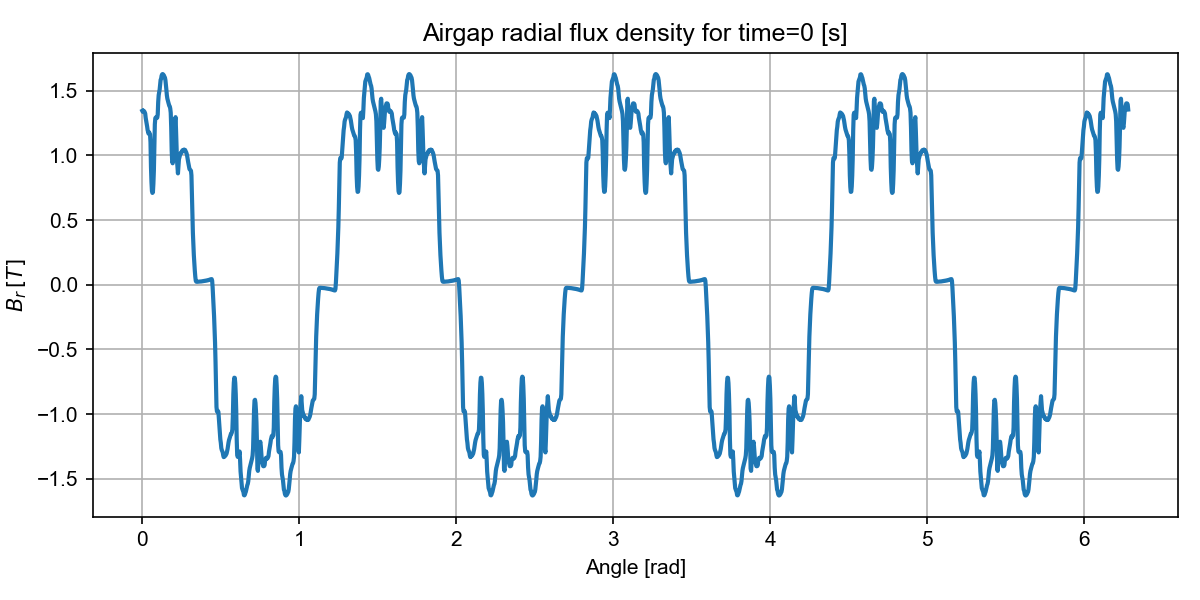

<IPython.core.display.Javascript object>


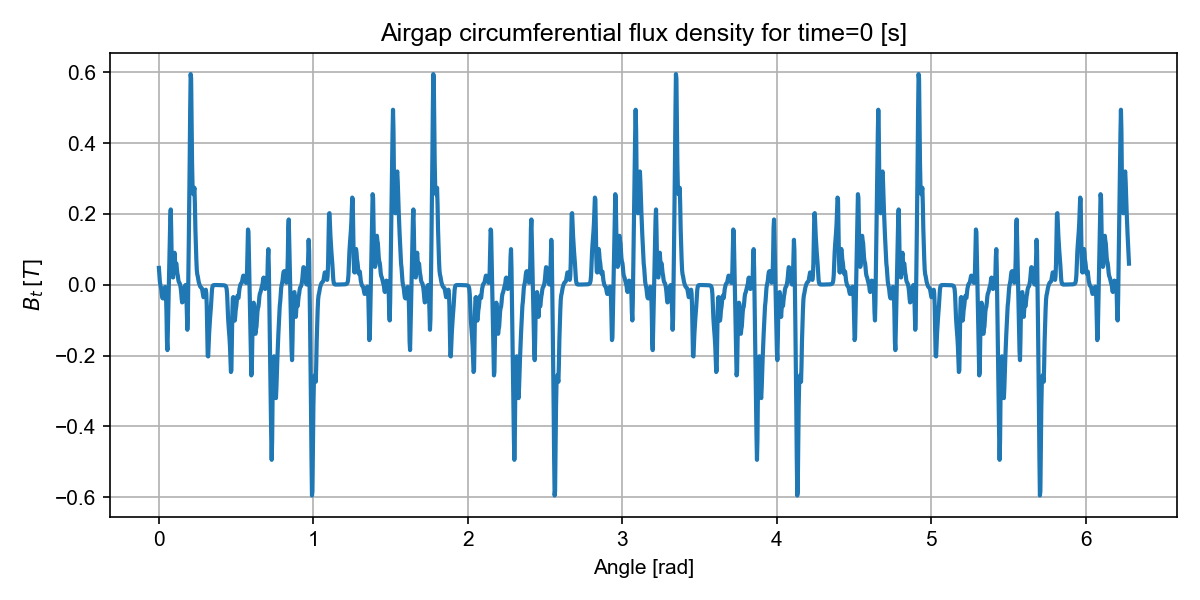

Index of the reference simulation in the list: None
Id: -135.4188051049254 , Iq: 113.62986941801093 , Tem_av_ref: None


<IPython.core.display.Javascript object>


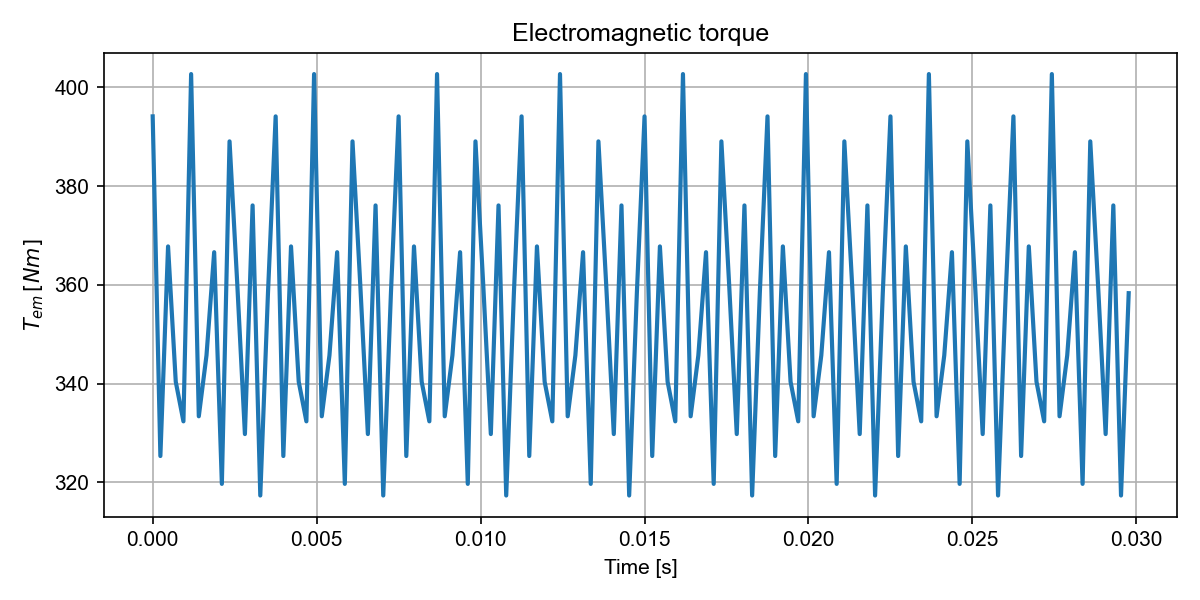

In [14]:
# Flux of the 3rd simulation
print("Id: "+str(Xout_vop.output_list[2].elec.OP.Id_ref)+" , Iq: "+str(Xout_vop.output_list[2].elec.OP.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[2].elec.Tem_av_ref))
Xout_vop.output_list[2].mag.B.plot_2D_Data("angle")

print("Index of the reference simulation in the list: "+str(Xout_vop.xoutput_ref_index))
print("Id: "+str(Xout_vop.output_list[8].elec.OP.Id_ref)+" , Iq: "+str(Xout_vop.output_list[8].elec.OP.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[8].elec.Tem_av_ref))
Xout_vop.output_list[8].mag.Tem.plot_2D_Data("time")

xOutput_dict의 모든 매개변수는 다른 매개변수의 함수로 플롯될 수 있습니다.

<IPython.core.display.Javascript object>


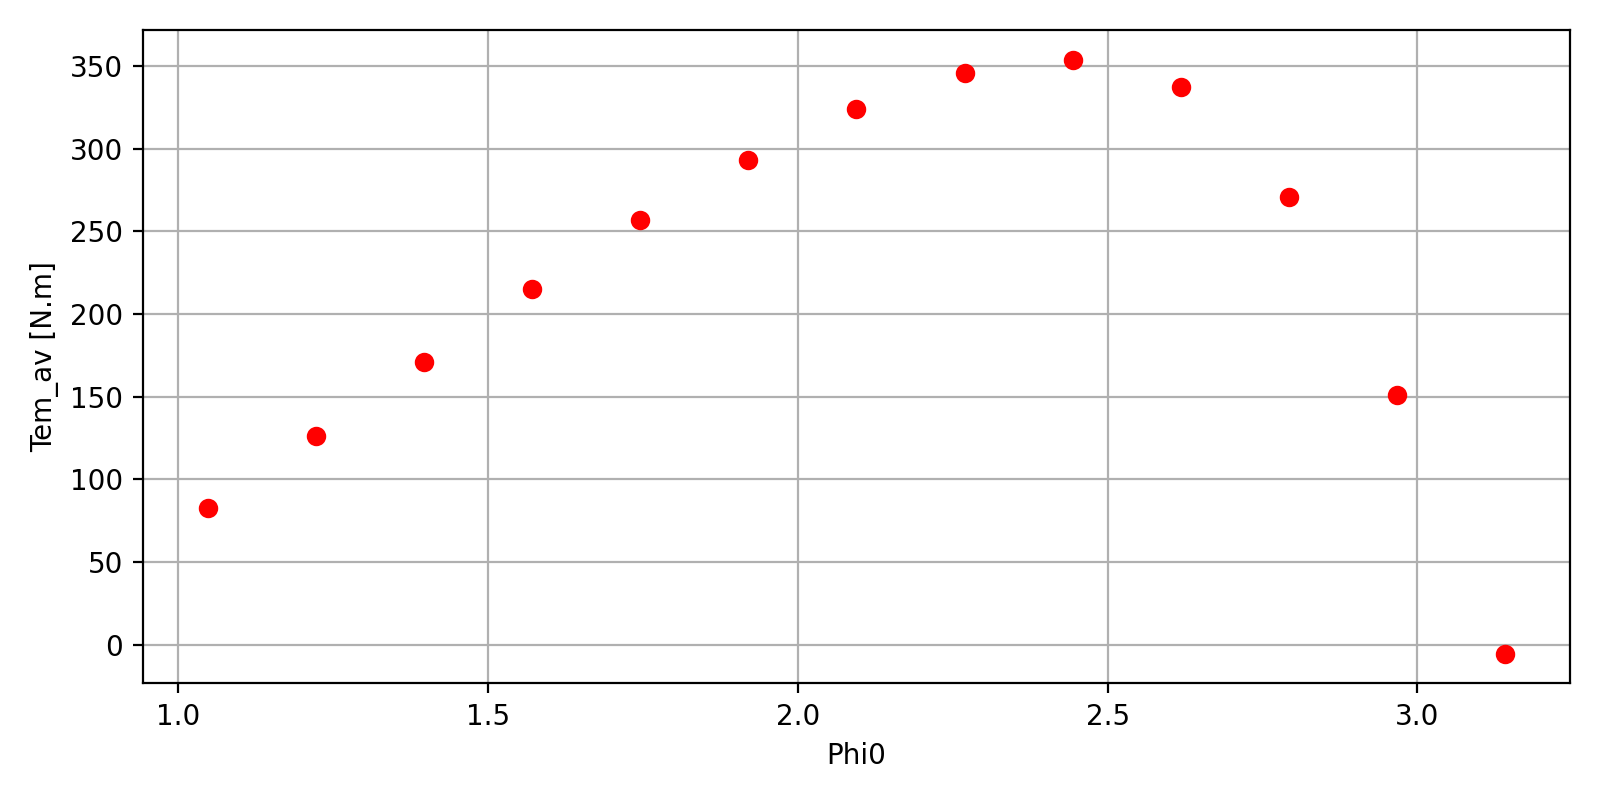

<IPython.core.display.Javascript object>


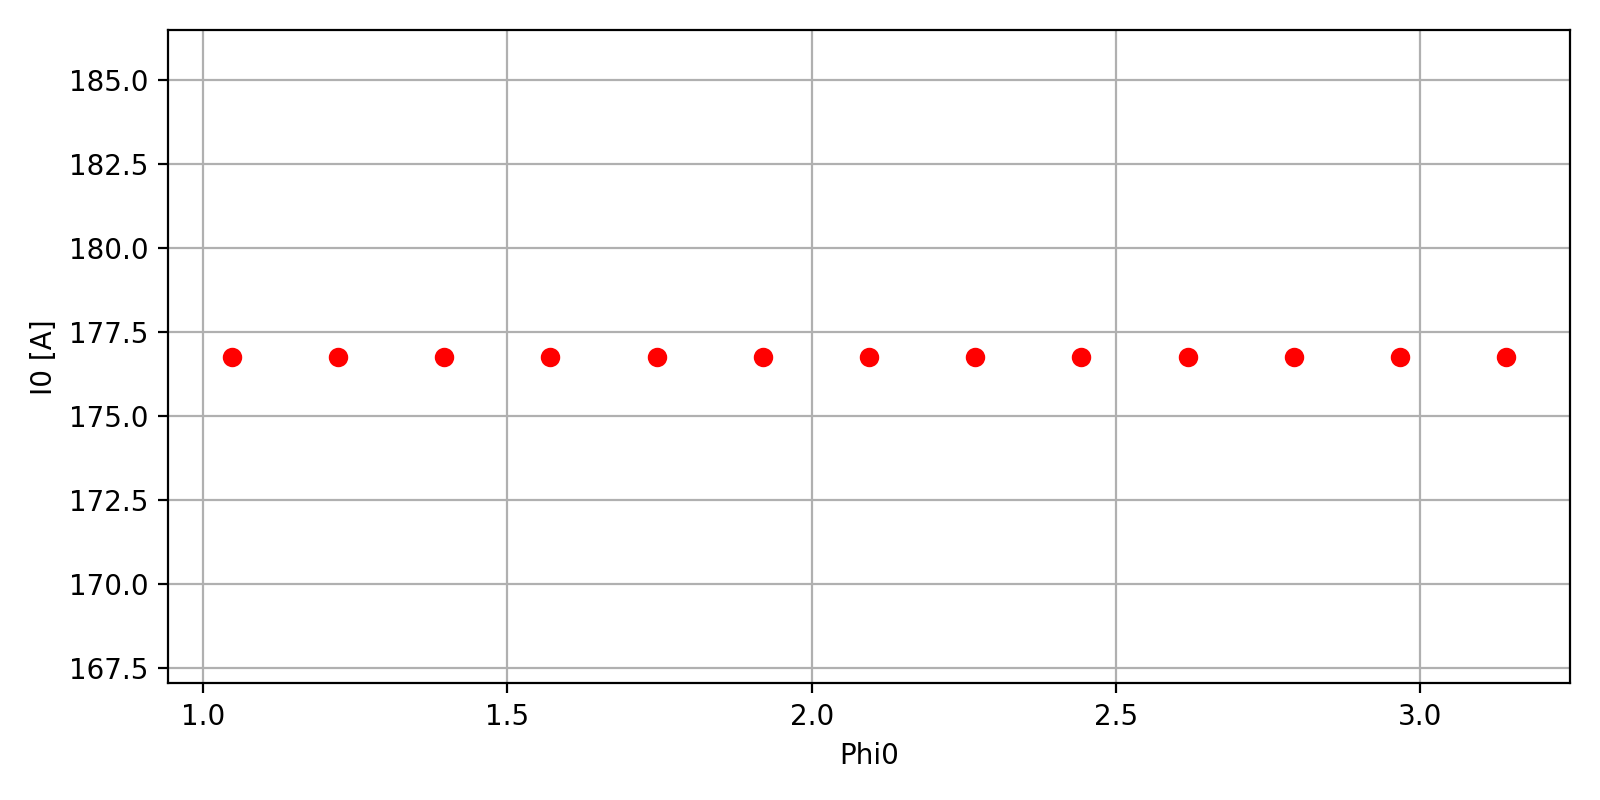

<IPython.core.display.Javascript object>


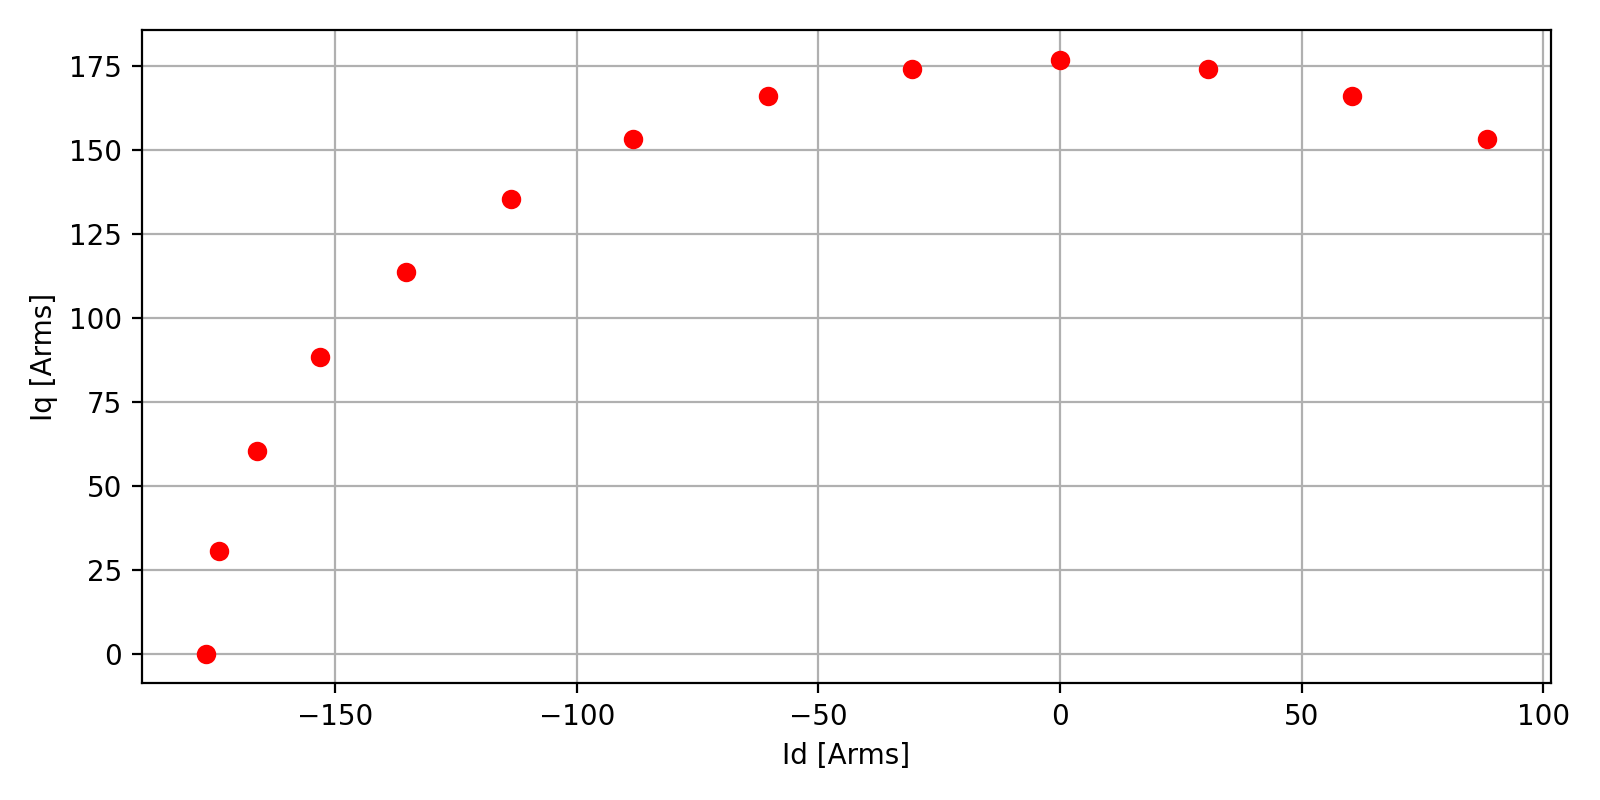

In [44]:
fig = Xout_vop.plot_multi("Phi0", "Tem_av")
fig = Xout_vop.plot_multi("Phi0", "I0")
fig = Xout_vop.plot_multi("Id", "Iq")


## 두 번째 다중 시뮬레이션 레이어 전용: 매개변수 스윕

pyleecan에서 Parameter Sweep은 VarParam 객체로 정의됩니다. 설계 변수는 ParamExplorer 개체로 설정되며 VarLoadCurrent(Id, Id, Tem_av...)와 동일한 Datakeeper가 자동으로 출력으로 정의됩니다. 다른 Datakeeper는 simu.var_simu.datakeeper_list에서 정의할 수 있습니다.

VarParam 및 VarLoadCurrent는 동일한 클래스 VarSimu에서 상속합니다. 이것이 VarLoadCurrent의 대부분의 매개변수를 VarParam에서도 사용할 수 있고 두 클래스가 동일한 동작을 공유하는 이유입니다. 주요 차이점은 시뮬레이션 목록이 정의되는 방식입니다. 기술적으로 VarLoadCurrent는 Id/Iq/Tem_av_ref에서 ParamExplorer를 사용하여 VarParam으로 정의할 수 있습니다.

이 튜토리얼에서는 하나의 ParamExplorer만 정의됩니다: 고정자 슬롯 개구부의 linspace. 각 시뮬레이션에는 다른 시스템이 있으므로 is_reuse_femm_file은 비활성화되고 is_keep_all_output은 xoutput 개체의 전체 내용을 표시하기 위해 활성화됩니다.

In [ ]:
## 임시 코드 Test set

from pyleecan.Classes.VarParam import VarParam
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval
simu_sweep = simu_ref.copy()

# Multi-simulation to change machine parameters (Temperature )
sweep = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
simu_sweep.var_simu = sweep
N_sweep = 8
ParamExplorerInterval[name="Temperature"]


In [19]:
from pyleecan.Classes.VarParam import VarParam
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval

simu_sweep = simu_ref.copy()

# Multi-simulation to change machine parameters
sweep = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
simu_sweep.var_simu = sweep
N_sweep = 8

# List of ParamExplorer to define multisimulation input values
simu_sweep.var_simu.paramexplorer_list = [
    ParamExplorerInterval(
        name="Stator slot opening",
        symbol="W0s",
        unit="m",
        setter="simu.machine.stator.slot.W0",
        getter="simu.machine.stator.slot.W0",
        min_value=0.1 * Toyota_Prius.stator.slot.W0,
        max_value=1.4 * Toyota_Prius.stator.slot.W0,
        N=N_sweep,
    )
]

print("Value used in the Parameter sweep: "+str(simu_sweep.var_simu.paramexplorer_list[0].get_value()))
print("Reference machine W0: "+str(Toyota_Prius.stator.slot.W0))

Value used in the Parameter sweep: [0.000193   0.00055143 0.00090986 0.00126829 0.00162671 0.00198514
 0.00234357 0.002702  ]
Reference machine W0: 0.00193


In [20]:
Xout_sweep = simu_sweep.run()

[16:49:15] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:49:15] Computing reference simulation for Parameter Sweep
[16:49:15] W0s: 8 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[16:49:15] Starting Magnetic module
[16:49:17] Solving time step 1 / 16 in FEMM
[16:49:18] Solving time step 5 / 16 in FEMM
[16:49:19] Solving time step 13 / 16 in FEMM
[16:49:20] Solving time step 9 / 16 in FEMM
[16:49:20] Solving time step 2 / 16 in FEMM
[16:49:21] Solving time step 6 / 16 in FEMM
[16:49:23] Solving time step 14 / 16 in FEMM
[16:49:24] Solving time step 3 / 16 in FEMM
[16:49:25] Solving time step 10 / 16 in FEMM
[16:49:25] Solving time step 7 / 16 in FEMM
[16:49:26] Solving time step 15 / 16 in FEMM
[16:49:27] Solving time step 4 / 16 in FEMM
[16:49:27] Solving time step 11 / 16 in FEMM
[16:49:29] Solving time step 8 / 16 in FEMM
[16:49:30] Solving time step 16 / 16 in FEMM
[16:49:31] Solving time step 12 / 16 in FEMM
[16:49:35] Parameter Sweep Reference Results: N0=

[16:51:50] Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=354.6 [N.m], Tem_rip_pp=88.36 [N.m], Tem_rip_norm=0.2492 [-], Pem_av=7.426e+04 [W]
[============================================      ]  88%
[16:51:50] Running simulation 8/8 with W0s=0.002702
[16:51:51] Starting Magnetic module
[16:51:53] Solving time step 1 / 16 in FEMM
[16:51:54] Solving time step 5 / 16 in FEMM
[16:51:55] Solving time step 13 / 16 in FEMM
[16:51:56] Solving time step 9 / 16 in FEMM
[16:51:58] Solving time step 6 / 16 in FEMM
[16:51:58] Solving time step 2 / 16 in FEMM
[16:52:01] Solving time step 14 / 16 in FEMM
[16:52:01] Solving time step 10 / 16 in FEMM
[16:52:03] Solving time step 7 / 16 in FEMM
[16:52:03] Solving time step 3 / 16 in FEMM
[16:52:04] Solving time step 15 / 16 in FEMM
[16:52:05] Solving time step 11 / 16 in FEMM
[16:52:05] Solving time step 8 / 16 in FEMM
[16:52:06] Solving time step 4 / 16 in FEMM
[16:52:07] Solving time step 12 / 16 in FEMM
[16:52:07] S

시뮬레이션의 로그를 통해 계산 상태를 단계별로 이해할 수 있습니다. 예상대로 참조 시뮬레이션이 먼저 계산됩니다(여전히 단일 작동 지점에 있음). 그런 다음, 8개의 시뮬레이션(값 목록에 없는 참조 W0) 각각은 다음과 같이 표시된 고정자 슬롯 개방에 대해 다른 값을 사용하여 동일한 작동 지점에서 실행됩니다.

**W0s=0.0020127143으로 시뮬레이션 7/8 실행**

그리고 이 시뮬레이션에 대한 데이터 키퍼 결과로 끝납니다.

**파라미터 스위프 결과: N0=2000[rpm], Id=-135.4[Arms], Iq=113.6[Arms], Tem_av=353.8[N.m], Tem_rip_pp=82.94[N.m], Tem_rip_norm=0.2344[-]**
    
is_keep_all_output이 True이면 N 시뮬레이션 중 하나가 참조와 일치하면 참조 출력이 output_list에 저장되고 그렇지 않으면 xoutput_ref에 저장됩니다.

In [21]:
print("Xout_sweep.xoutput_ref:" +str(type(Xout_sweep.xoutput_ref)))
print("Xout_sweep.xoutput_ref_index:" +str(Xout_sweep.xoutput_ref_index))
print("\nXout_vop.xoutput_ref:" +str(Xout_vop.xoutput_ref))
print("Xout_vop.xoutput_ref_index:" +str(Xout_vop.xoutput_ref_index))

# A function enables to acces the reference output in all the cases
xoutput_ref = Xout_sweep.get_xoutput_ref()

Xout_sweep.xoutput_ref:<class 'pyleecan.Classes.Output.Output'>
Xout_sweep.xoutput_ref_index:None

Xout_vop.xoutput_ref:parent = <class 'pyleecan.Classes.XOutput.XOutput'> object
simu = parent = <class 'pyleecan.Classes.Output.Output'> object
	name = "tuto_multi"
	desc = ""
	machine = parent = <class 'pyleecan.Classes.Simu1.Simu1'> object
		frame = None
		
		shaft = parent = <class 'pyleecan.Classes.MachineIPMSM.MachineIPMSM'> object
			Lshaft = 0.1
			mat_type = parent = <class 'pyleecan.Classes.Shaft.Shaft'> object
				name = "M400-50A"
				is_isotropic = False
				elec = parent = <class 'pyleecan.Classes.Material.Material'> object
					rho = 1
					epsr = 1
					alpha = 1
				mag = parent = <class 'pyleecan.Classes.Material.Material'> object
					mur_lin = 2500.0
					Hc = 0
					Brm20 = 0
					alpha_Br = 0
					Wlam = 0.0005
					BH_curve = parent = <class 'pyleecan.Classes.MatMagnetics.MatMagnetics'> object
						is_transpose = False
						value = 
						[[0.000e+00 0.000e+00]
 [1

output_list, xoutput_dict 및 각 플롯 명령은 VarLoadCurrent와 동일한 방식으로 작동합니다. ParamExplorer는 plot_multi에도 사용할 수 있습니다.

output_list, xoutput_dict and the respective plot commands work the same way as for VarLoadCurrent. The ParamExplorer are also available for plot_multi:

<IPython.core.display.Javascript object>


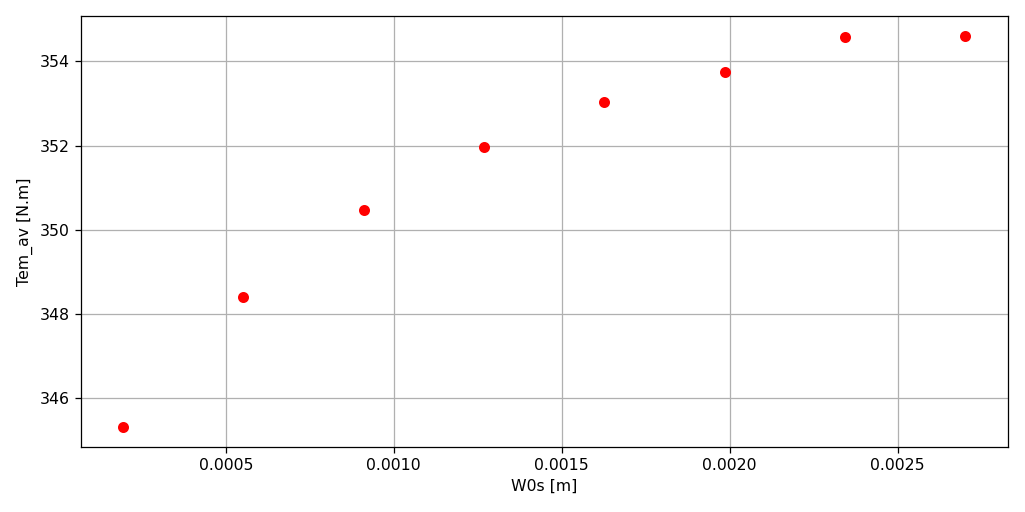

In [22]:
Xout_sweep.plot_multi("W0s","Tem_av")

각 출력에는 이를 계산한 시뮬레이션이 포함되어 있습니다. is_keep_all_output과 함께 매개변수 스윕을 사용하면 output_list에서 생성된 각 시뮬레이션 및 기계에 액세스할 수 있습니다. 다음 코드는 가장 높은 토크로 기계를 추출합니다. 상응하는 W0를 얻기 위해 ParamExplorerInterval은 ParamExplorerSet으로 변환되어 시뮬레이션 중에 사용된 실제 값을 저장합니다.

As a reminder, each output contains the simulation that computed it. Using Parameter sweep with is_keep_all_output enables to access each generated simulation and machine in the output_list. The following code will extract the machine with the highest torque. To get the corresponding W0s, the ParamExplorerInterval was converted to a ParamExplorerSet to store the actual values used during the simulation. 

In [23]:
from numpy import argmax, max as np_max
# Find the simulation with the most torque
Tmax = np_max(Xout_sweep.xoutput_dict["Tem_av"].result)
Tmax_id = int(argmax(Xout_sweep.xoutput_dict["Tem_av"].result))
print("Max Torque is "+str(Tmax)+" [N.m], for simulation index "+str(Tmax_id))

# Find the corresponding W0s
print(type(Xout_sweep.paramexplorer_list[0]))
W0s_val = Xout_sweep.paramexplorer_list[0].get_value()
print(W0s_val)

print("Corresponding W0s is " + str(W0s_val[Tmax_id]))

# To save the simulation or machine for further modifications/computations
# Xout_sweep.output_list[Tmax_id].simu.save(path/to/json/file)
# Xout_sweep.output_list[Tmax_id].simu.machine.save(path/to/json/file)

NameError: name 'Xout_sweep' is not defined

It is also possible to access the machine plot command to check the modifications:

<IPython.core.display.Javascript object>


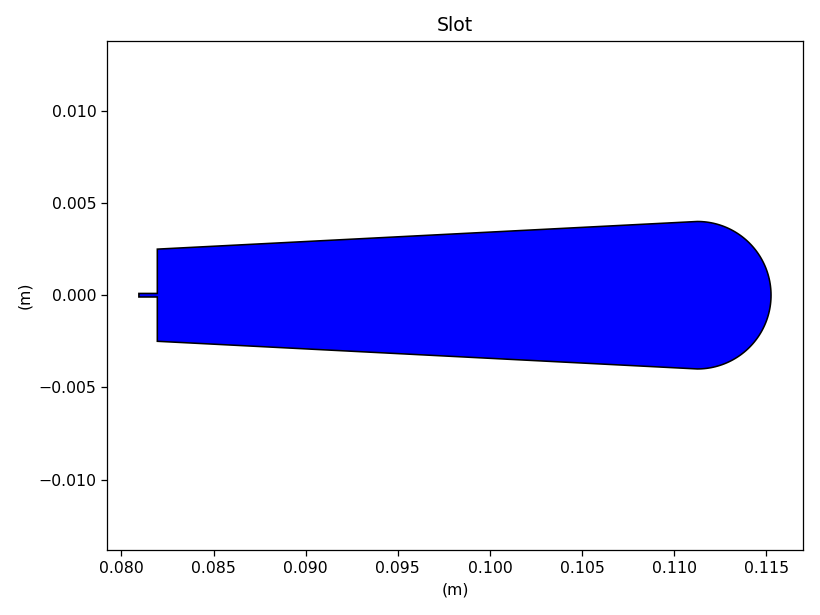

<IPython.core.display.Javascript object>


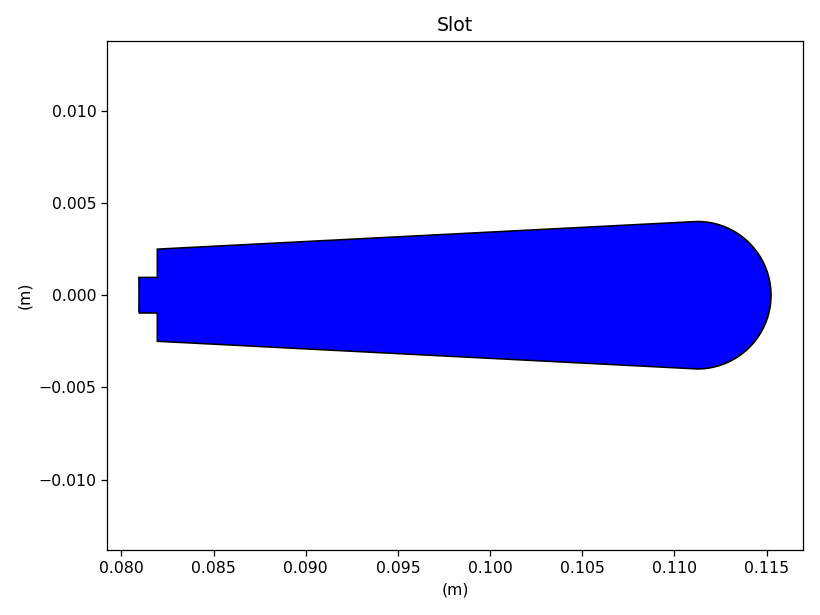

<IPython.core.display.Javascript object>


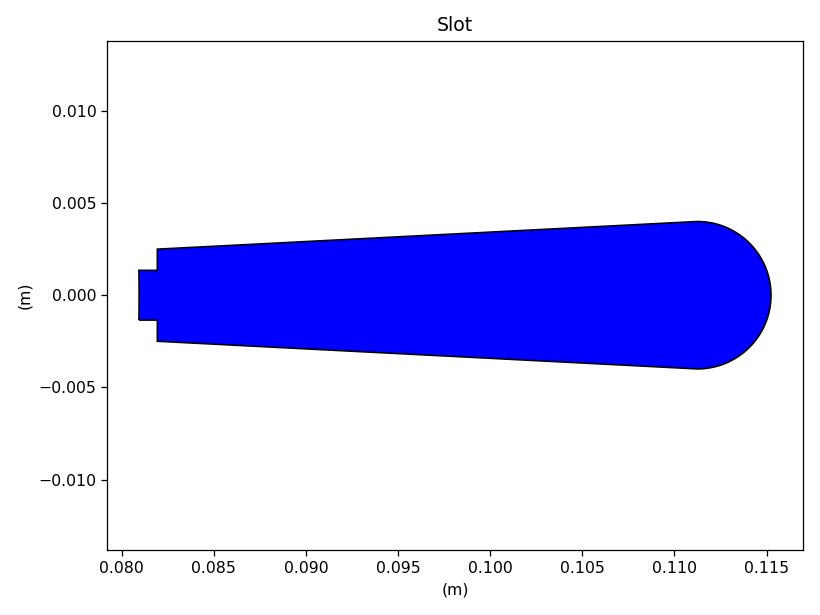

In [24]:
Xout_sweep.output_list[0].simu.machine.stator.slot.plot()
Xout_sweep.xoutput_ref.simu.machine.stator.slot.plot()
Xout_sweep.output_list[-1].simu.machine.stator.slot.plot()

## Both multi-simulation layers: Parameter-sweep of variable speed simulation

지금은 다중 시뮬레이션을 정의하기 위해 VarSimu 객체로 Simulation의 var_simu 속성을 설정했습니다. 다중 시뮬레이션의 다중 시뮬레이션을 정의하기 위해 VarSimu 객체도 사용하는 VarSimu의 var_simu 속성을 사용할 수 있습니다. 이 정의 원칙은 "시뮬레이션 계층"의 수에 제한이 없지만 두 개 이상의 계층을 필요로 하는 용도는 없습니다.

For now, we have set the var_simu property of Simulation with a VarSimu object to define a multi-simulation. To define a multi-simulation of multi-simulation, we can use the var_simu property of VarSimu which also take a VarSimu object. This definition principal has no limit in the number of "simulation layer" but no usage should require more than two layers.

In [25]:
multi_simu = simu_ref.copy()
multi_simu.var_simu = sweep.copy()
multi_simu.var_simu.var_simu = varload.copy()

이 시뮬레이션의 워크플로는 다음과 같습니다.
- Pyleecan은 simu.var_simu => VarParam.run을 확인합니다.
- VarParam은 simu.var_simu = simu.var_simu.var_simu로 참조 시뮬레이션을 정의합니다.
- VarParam이 referencece 시뮬레이션을 실행하고 simu.var_simu => VarLoadCurrent.run을 확인하십시오.
- VarParam의 참조 시뮬레이션은 simu.var_simu = simu.var_simu.var_simu(None)로 자체 참조 시뮬레이션을 정의하는 VarLoadCurrent 시뮬레이션입니다.
- VarLoadCurrent의 참조 시뮬레이션을 실행할 때 simu.var_simu는 None이므로 모델을 실행합니다(이 시뮬레이션은 이전에 정의된 exaclty simu_ref입니다).
- Pyleecan은 VarLoadCurrent의 N_speed 시뮬레이션을 실행합니다.
- Pyleecan은 VarLoadCurrent인 VarParam의 N_sweep 시뮬레이션을 생성하고 모두 실행합니다.
- 각 VarLoadCurrent 시뮬레이션에 대해 참조 시뮬레이션이 정의된 다음 N_speed 시뮬레이션이 정의됩니다.

따라서 이 시뮬레이션은 (1+N_sweep) * (1+N_speed) 시뮬레이션을 실행합니다. 이것이 참조 시뮬레이션이 양쪽에서 하나의 계산을 건너뛰기 위해 N 시뮬레이션의 일부인지 확인하는 것이 중요한 이유입니다.

각 시뮬레이션 레이어에는 다음을 수행할 수 있는 고유한 속성이 있습니다.

The workflow of this simulation is the following:
- Pyleecan checks simu.var_simu => VarParam.run
- VarParam defines its reference simulation with simu.var_simu = simu.var_simu.var_simu
- VarParam run its referencece simulation, check simu.var_simu => VarLoadCurrent.run
- The reference simulation of VarParam is a VarLoadCurrent simulation that defines its own reference simulation with simu.var_simu = simu.var_simu.var_simu (which is None)
- When running the reference simulation of VarLoadCurrent, simu.var_simu is None so we run the models (this simulation is then exaclty simu_ref defined previously)
- Pyleecan run the N_speed simulations of the VarLoadCurrent
- Pyleecan generates the N_sweep simulations of the VarParam which are VarLoadCurrent and run them all
- For each VarLoadCurrent simulation, a reference simulation is defined then the N_speed simulations

So this simulation will run (1+N_sweep) * (1+N_speed) simulations. This is why it is important to make sure that the reference simulation is part of the N simulations to skip one computation on both sides.

Each simulation layer has its own properties which enables to do the following:

In [26]:
# VarParam => All machine are different
multi_simu.var_simu.is_reuse_femm_file = False
# VarLoadCurrent => All machines are the same
multi_simu.var_simu.var_simu.is_reuse_femm_file = True

출력 구조를 설명하기 위해 이 자습서에서는 is_keep_all_output 옵션을 다시 사용합니다. 계산 속도를 높이고 메모리 사용량을 줄이기 위해 시뮬레이션 횟수를 줄입니다.

To explain the output structure, this tutorial will again use the is_keep_all_output option. To speed up the computation and reduce the memory usage the number of simulation is reduced:

In [27]:
# VarParam
multi_simu.var_simu.is_keep_all_output = True
multi_simu.var_simu.datakeeper_list = list()  # reset datakeeper list
multi_simu.var_simu.paramexplorer_list[0].N = 4
multi_simu.var_simu.paramexplorer_list[0].max_value = Toyota_Prius.stator.slot.W0  # Ref is in the N simu
# VarLoadCurrent
multi_simu.var_simu.var_simu.is_keep_all_output = True
multi_simu.var_simu.var_simu.datakeeper_list = list()  # reset datakeeper list
multi_simu.var_simu.var_simu.OP_matrix = OP_matrix[:-4, :]
print("OP matrix")
print(multi_simu.var_simu.var_simu.OP_matrix)
# Reference simulation
multi_simu.input.Nt_tot = 64

OP matrix
[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]]


For a better understanding of the logs, the VarLoadCurrent simulation log can be filtered with:

In [17]:
multi_simu.layer_log_warn = 2

NameError: name 'multi_simu' is not defined

In [29]:
Xout_multi = multi_simu.run()

[16:52:52] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:52:52] Computing reference simulation for Parameter Sweep
[16:52:52] W0s: 4 values from 0.000193 to 0.00193 (ref=0.00193) [m]
[16:52:52] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[16:52:52]     Computing reference simulation for Variable Load
[16:53:06]     Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Tem_av=353.8 [N.m], Tem_rip_pp=76.83 [N.m], Tem_rip_norm=0.2171 [-], Pem_av=7.41e+04 [W]
               [=====                                             ]  10%
[16:53:06]     Variable Load: Using same FEMM file for all simulation (D:\GitHub\pyleecan-public\pyleecan\Results\tuto_multi\Femm\Toyota_Prius_model.fem)
[16:53:06]     Running simulation 1/9 with N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms]
[16:53:19]     Variable Load Results: N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [

               [=============================================     ]  90%
[16:55:51]     Running simulation 9/9 with N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms]
[16:55:59]     Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Tem_av=345 [N.m], Tem_rip_pp=81.17 [N.m], Tem_rip_norm=0.2353 [-], Pem_av=7.226e+04 [W]
               [==================================================] 100%
[16:55:59] Parameter Sweep Results: Max_Tem_av=345 [N.m], Max_Tem_rip_pp=91.1 [N.m], Max_Tem_rip_norm=0.314 [-]
[====================                              ]  40%
[16:55:59] Running simulation 2/4 with W0s=0.000772
[16:56:00] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[16:56:00]     Computing reference simulation for Variable Load
[16:56:09]     Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Te

               [========================================          ]  80%
[16:58:24]     Running simulation 8/9 with N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms]
[16:58:33]     Variable Load Results: N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms], I0=176.8 [A], Phi0=2.269 [], Tem_av_ref=None [N.m], Tem_av=344.1 [N.m], Tem_rip_pp=85.27 [N.m], Tem_rip_norm=0.2478 [-], Pem_av=7.207e+04 [W]
               [=============================================     ]  90%
[16:58:33]     Running simulation 9/9 with N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms]
[16:58:41]     Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Tem_av=352.2 [N.m], Tem_rip_pp=75.73 [N.m], Tem_rip_norm=0.215 [-], Pem_av=7.377e+04 [W]
               [==================================================] 100%
[16:58:41] Parameter Sweep Results: Max_Tem_av=352.2 [N.m], Max_Tem_rip_pp=85.27 [N.m], Max_Tem_rip_norm=0.3043 [-]
[=====================

Again, the logs enable to follow step by step each layer of the simulation with their corresponding input and output.
The datakeeper of the VarLoadCurrent are the same as previously:
**Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=353 [N.m], Tem_av=353.3 [N.m], Tem_rip_pp=73.53 [N.m], Tem_rip_norm=0.2081 [-]**

But the VarParam Datakeeper are now:

**Parameter Sweep Results: Max_Tem_av=345 [N.m], Max_Tem_rip_pp=90.72 [N.m], Max_Tem_rip_norm=0.3105 [-]**

The reason is that now the parameter sweep is running on a multi-simulation. Thus, Tem_av is now an array as a function of the operating point. So instead of storing Tem_av, the datakeeper now store the maximum of the Tem_av DataKeeper of the VarLoadCurrent simulation ("max(output.xoutput_dict['Tem_av'].result)")

The xoutput_dict contains only the information related to the VarParm:

Values available in XOutput:
dict_keys(['Max_Tem_av', 'Max_Tem_rip_pp', 'Max_Tem_rip_norm'])

Maximum Torque for each Design:
[345.0304985573581, 349.7642780183083, 352.22143610291545, 353.80472945261613]
W0s for each Design:
[0.00019300000000000003, 0.000772, 0.001351, 0.00193]


<IPython.core.display.Javascript object>


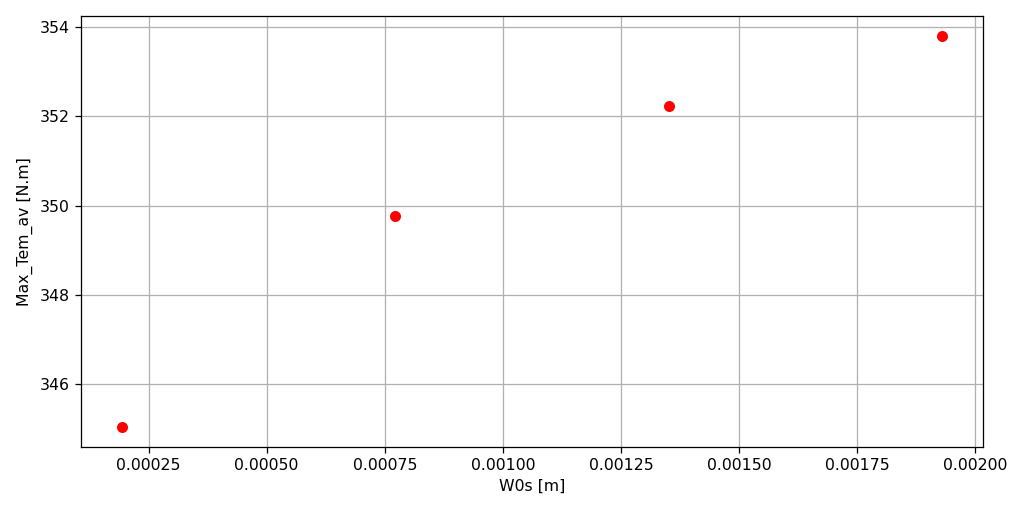

In [30]:
print("Values available in XOutput:")
print(Xout_multi.xoutput_dict.keys())

print("\nMaximum Torque for each Design:")
print(Xout_multi.xoutput_dict["Max_Tem_av"].result)
print("W0s for each Design:")
print(Xout_multi.paramexplorer_list[0].get_value())

Xout_multi.plot_multi("W0s", "Max_Tem_av")

In [31]:
Xout_multi.xoutput_dict["Max_Tem_av"].result

[345.0304985573581, 349.7642780183083, 352.22143610291545, 353.80472945261613]

is_keep_all_output 옵션이 활성화되어 output_list를 사용할 수 있지만 이제 VarLoadCurrent 계산으로 인한 xouput이 포함됩니다. 그러면 모든 VarLoadCurrent DataKeeper를 사용할 수 있습니다.

As the is_keep_all_output option was activated, output_list is available but now it contains the xouput resulting from the VarLoadCurrent computation. Then all the VarLoadCurrent DataKeeper are available.

In [32]:
print(type(Xout_multi.output_list[0]))
print(type(Xout_sweep.output_list[0]))

print("\nDatakeeper of VarLoadCurrent simulation of Design 0")
print(Xout_multi.output_list[0].xoutput_dict.keys())
print("Average torque for each operating point of Design 0")
print(Xout_multi.output_list[0].xoutput_dict["Tem_av"].result)

# To save the VarLoadCurrent simulation or machine for further modifications/computations
# Xout_multi.output_list[0].simu.save(path/to/json/file)
# Xout_multi.output_list[0].simu.machine.save(path/to/json/file)

<class 'pyleecan.Classes.XOutput.XOutput'>
<class 'pyleecan.Classes.Output.Output'>

Datakeeper of VarLoadCurrent simulation of Design 0
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm', 'Pem_av'])
Average torque for each operating point of Design 0
[80.94610281890381, 123.5638043502944, 167.40952551307998, 210.67150583907878, 251.3183718014907, 287.2531533915088, 316.82132486878527, 337.65567569144696, 345.0304985573581]


VarLoadCurrent도 is_keep_all_output 옵션이 활성화되어 있으므로 각 시뮬레이션의 출력을 사용할 수 있으며 해당 플롯 명령을 호출할 수 있습니다.

As the VarLoadCurrent also have the is_keep_all_output option activated, the output of each simulation is available and  it is possible to call the corresponding plot command

In [16]:
Xout_multi.output_list[-1].plot_multi("Phi0", "Tem_av")
# Torque at the first Operating point for the Last design
Xout_multi.output_list[-1].output_list[0].mag.Tem.plot_2D_Data("time")
# Flux of the 4th Operating point for the Last design
Xout_multi.output_list[-1].output_list[3].mag.B.plot_2D_Data("angle")


NameError: name 'Xout_multi' is not defined